In [192]:
%load_ext autoreload
%autoreload 2

from IPython.display import Math, Latex

import pandas as pd, cvxpy as cp, numpy as np, matplotlib as mpl  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from matplotlib.patches import FancyArrowPatch, Polygon  # type: ignore
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from scipy.integrate import quad  # type: ignore
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

import importlib, itertools, csv, concurrent.futures
import os, math, sys, json, pickle, shutil, time, functools

from typing import Dict, List, Any, Optional, Literal
from tqdm.notebook import tqdm

from Utils import Notebook, tex, gph, sgn, nm, ds
from Simulator import open_loop, closed_loop_setm
from optimization import DisturbedSaturatedPETC as DSPETC

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'tick_fontsize': 16,
    },
    'legend': {'fontsize': 16}
}

colors_list = plt.get_cmap('tab20').colors
Notebook.setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


LaTeX has been enabled for text rendering.


### Definição da Planta

In [193]:
experiment_config_filename = 'exp-01'

with open(f"experiment-datas/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

plant = ds.StateSpace(data=config["plant"], name='plant')
latex_expr = plant.get_latex_equations()
print("Equações que regem a dinâmica da planta:")
tex.display_latex(latex_expr)

Equações que regem a dinâmica da planta:


<IPython.core.display.Latex object>

### Simulação da Planta em Malha Aberta

In [ ]:
x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
config['duration'] = 10
plant_output, time_history, signal_control = open_loop(
    x0, config, u_constant=0.0)

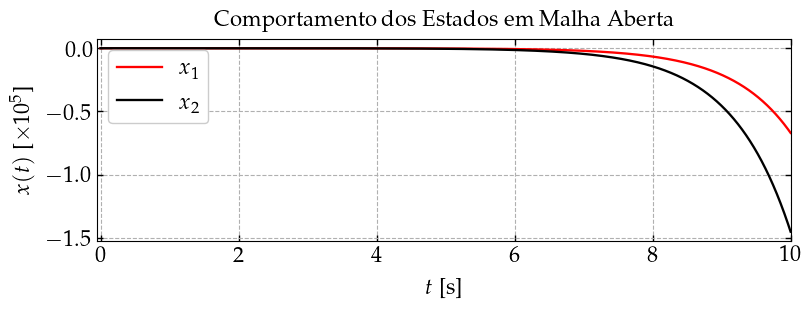

In [195]:
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

_ = gph.plot(
    axs['x'], time_history, plant_output,
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$x(t)$', color=['red', 'black'],
    label=[fr'$x_1$', fr'$x_2$'],
    cfg=cfg, title='Comportamento dos Estados em Malha Aberta',
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

### Projeto do Controlador e do ETM

In [196]:
def solve_problem(
    h: float,
    υ: float,
    eps: float = 1e-6,
):
  n_x = plant.nx
  n_u = plant.nu

  Onx = np.zeros((n_x, n_x))

  matrices = plant.evaluate_matrices(None, None, None)
  A = matrices['A']
  B = matrices['B']

  e = nm.get_e(5 * [n_x])

  for i in range(1, len(e)):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x, 2 * n_x), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_x))
  Ktil = cp.Variable((n_u, n_x))

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, e[1].shape[1]))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])

  def get_Θ(ω):
    Bscr = A @ X @ e[1] + B @ Ktil @ e[2] + + B @ Ktil @ e[5] - X @ e[4]
    Θ1 = (e[1] - e[2]).T @ S1til @ (e[1] - e[2]) + \
        nm.He((e[1] - e[2]).T @ (S2til @ e[2] + S3til @ e[5]))
    Θ2 = nm.He(e[3].T @ (Q2til @ e[2] + Q3til @ e[5]))
    Θ3 = nm.He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] + Q3til @ e[5]))
    Θ4 = nm.He(e[4].T @ (S1til @ (e[1] - e[2]) + S2til @
               e[2] + S3til @ e[5])) + e[4].T @ Rtil @ e[4]
    return nm.He(e[1].T @ Ptil @ e[4] + Fscr @ Bscr - κ2.T @ Ytil) - e[5].T @ Ξtil @ e[5] - \
        Θ1 - ω * Θ2 - h * e[3].T @ Q1til @ e[3] + \
        (h - ω) * Θ3 + (h - 2.0 * ω) * κ1.T @ Mtil @ κ1 + (h - ω) * Θ4

  def get_Λ():
    Γ1_11 = get_Θ(0)
    Γ1_12 = e[2].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12],
                  [Γ1_21, Γ1_22]])

    Γ2_11 = get_Θ(h)
    Γ2_12 = Ytil.T
    Γ2_13 = e[2].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33]])

    return Γ1, Γ2

  Γ1, Γ2 = get_Λ()
  constraints += [Γ1 << -eps * np.eye(Γ1.shape[0])]
  constraints += [Γ2 << -eps * np.eye(Γ2.shape[0])]

  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil))
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)
    P = Xinv.T @ Ptil.value @ Xinv
    S2 = Xinv.T @ S2til.value @ Xinv
    K = Ktil.value @ Xinv
    etm_results = {'Ξ': Ξ, 'Ψ': Ψ}
    design_results = {
        'optimal_value': prob.value,
        'etm': etm_results,
        'controller': {'K': K},
        'lyapunov': [P, S2],
    }
  else:
    design_results = None

  return design_results

In [197]:
prob_results = solve_problem(h=10e-3, υ=1e-1)

if prob_results is not None:
  Ξ, Ψ = prob_results['etm']['Ξ'], prob_results['etm']['Ψ']
  K = prob_results['controller']['K']
  P, S2 = prob_results['lyapunov']

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  display(Math(rf'K = {tex.mat2tex(K)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [198]:
config["design_params"]['h'] = 10e-3
config["duration"] = 10

In [199]:
y_hist, time_history, u_hist, event_times = closed_loop_setm(
    x0, config, prob_results)

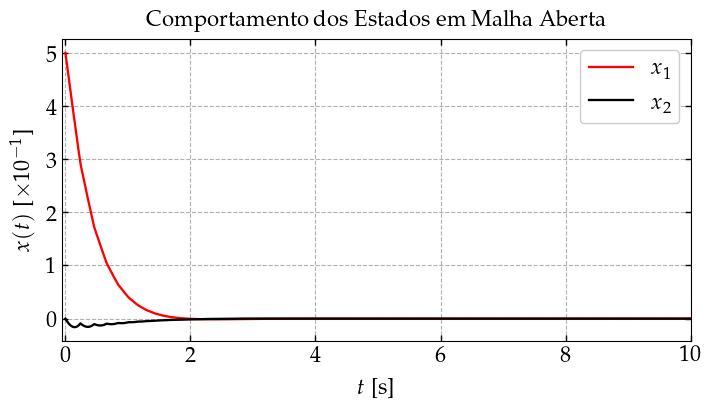

In [200]:
fig = plt.figure(figsize=(7, 4), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

_ = gph.plot(
    axs['x'], time_history, y_hist,
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$x(t)$', color=['red', 'black'],
    label=[fr'$x_1$', fr'$x_2$'],
    cfg=cfg, title='Comportamento dos Estados em Malha Aberta',
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

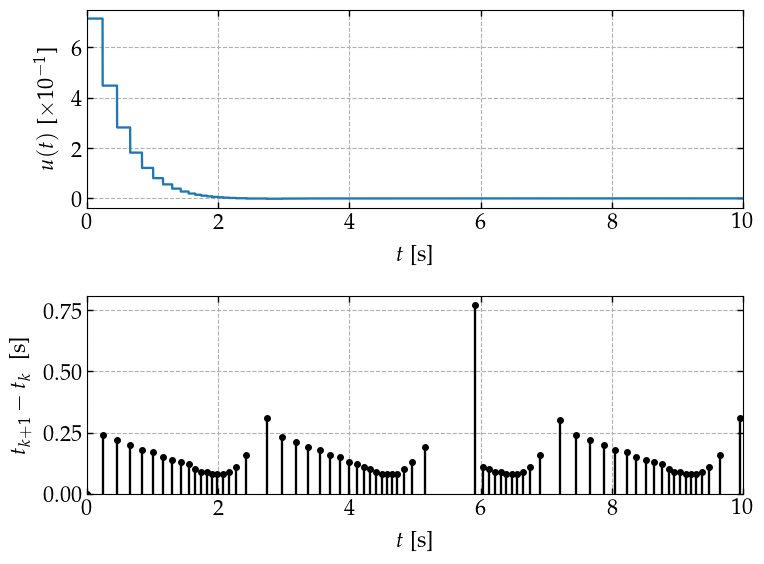

In [201]:
mosaic = [['control'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

inter_event_times = nm.compute_deltas(event_times)

for i in range(plant.nu):
  gph.plot(
      axs['control'], time_history, u_hist, xlabel='$t$', x_unit='s', x_use_prefixes=True,
      ylabel=r'$u(t)$', y_pad=(0.05, 0.05),
      cfg={**cfg, 'style': {'color': colors_list[0], "linestyle": ["-"], }},)

gph.stem(
    axs['iet'], event_times, inter_event_times,
    reuse_previous=False, y_pad=(0.0, 0.05), x_use_prefixes=True,
    xlabel='$t$', x_unit='s', x_range=(0.0, time_history[-1]),
    ylabel='$t_{k+1} - t_k\\;$', y_unit='s', y_use_prefixes=True,
    cfg={**cfg, 'limits': {'x_min': 0, 'x_max': time_history[-1]}})

plt.tight_layout(pad=2.)